# 1. 概述

---

- 资产配置解决的问题是：怎样在不同的资产上分配资金
- 在进行资产配置时，最经典运用也最广泛的当属Harry Markowitz的均值-方差分析理论，但是均方差优化有个关键的输入变量——预期收益率，而优化的组合权重对预期收益率又特别的敏感，导致均值-方差分析存在一定的缺陷。Black-Litterman模型是对MVO的一个扩展，其主要的贡献是提供了一个理论框架，能够将市场均衡收益和**个人观点**整合到一块，用以重新估计更可靠的预期收益率，然后将预期收益率带入均值-方差分析，得出最优资产配置。

- 本文给出了一系列可以直接用于计算基于Black-Litterman模型的最优投资组合的函数，包括
    - describe(return_table, is_print=True)
    - get_BL_efficient_frontier(return_table,tau=0.05,P=None,Q=None,Omega=None,allow_short=False, n_samples=25)
    - draw_efficient_frontier(effcient_frontier_output)
    - get_BL_minimum_variance_portfolio(return_table,tau=0.05,P=None,Q=None,Omega=None, allow_short=False, show_details=True)
    - get_BL_maximum_utility_portfolio(return_table,tau=0.05,P=None,Q=None,Omega=None, risk_aversion=3., allow_short=False, show_details=True)
    - get_maximum_sharpe_portfolio(return_table, riskfree_rate=0.,tau=0.05,P=None,Q=None,Omega=None,allow_short=False, show_details=True)

# 2. Black-Litterman模型简介

---

- 传统均值-方差分析基于以下假设
	- a) 所有资产的收益率都满足正态分布 或者 b) 投资者只关心收益的均值和方差（即一阶矩和二阶矩）
	- 用于分析的所有资产都是可交易的，这里的可交易是指可以进行任意数量的做多和做空
	- 没有交易成本
- 在以上假设下，均值方差优化会出现不合情理的配置：无限制条件下，会出现对某些资产的强烈卖空，当有卖空限制时，某些资产的配置为零，同时在某些小市值资产配有较大的权重。问题的原因有：
    - 期望收益非常难以估计，一个标准的优化模型，需要对所有资产都有收益估计，因此投资者就会基于他们常用的历史收益和一系列假设条件进行估计，导致不正确估计的产生。
    - 组合权重对收益估计的变动非常敏感。
    - 传统模型无法区分不同可信度的观点，观点不能很好被模型所表达。
    
-  B-L 模型在均衡收益基础上通过**投资者观点修正了期望收益**，使得均值方差组合优化中的期望收益更为合理，而且还将投资者观点融入进了模型，在一定程度上是对马克维兹均值方差组合理论的改进。主要思路如下：
	- (1) 计算得到先验的期望收益
	- (2) 个人观点模型化，观点可以涉及单个资产，也可以涉及多个资产乃至所有资产，也可以有多个资产，最后按照一定的规则将所有观点构建成矩阵P、Q和Ω
    - (3) 计算整合后调整的预期收益率、调整后的收益率方差
$$ \widehat \Pi = \Pi +τΣP'(Ω+τ PΣP')^{-1}(Q− PΠ)$$	$$ \ M = \tau\Sigma - \tau \Sigma P'[P \Sigma P' + \Omega]^{-1}P\tau \Sigma$$
$$ \Sigma_p = \Sigma + M$$
	- (4) 根据调整后的期望收益，利用均值方差模型计算最优权重。
    $$ \widehat w =  (\delta \Sigma_p)^{-1} \widehat \Pi  (无卖空约束情况)$$ 
    
- 参数解释：
	- $\Pi$为先验的期望收益，通过历史平均年化收益得到
	- $\widehat \Pi$为个人观点调整后的期望收益
	- $\Sigma$为资产收益率之间的协方差矩阵
	- $M$为后验分布预期收益率的方差
	- $\Sigma_p$为调整后预期收益率方差
	- $\tau$为均衡收益方差的刻度值，体现了对个人观点在总体估计中的权重，通常取值在0.025~0.05
	- $\delta$为风险厌恶系数(risk averse)	
	- $\widehat w$为调整后的资产配置权重 
	- $P 、Q 、\Omega$为观点矩阵

# 2. 个人观点矩阵生成示例：

---

- 考虑有K个观点n个资产的例子，此时，P就是k\*n矩阵，每一行代表一个观点，Q为K\*1矩阵，存放每个观点的超额收益。Ω是k\*k对角矩阵，对角线上的每一个元素代表该观点的方差，与对该观点的置信程度成反比，在学术界常用的公式是：$$  \Omega = P\tau \Sigma P^{T}$$

- 假设有4种资产、2个观点
	- 观点一：资产1比资产3的预期收益率要多2%，置信度为w1；
	- 观点二：资产2的预期收益率为3%，置信度为w2。由于资产4没有任何观点，所以资产4的预期收益不需要调整，随后得出如下矩阵：
$$  P = \begin{pmatrix} 1 & 0 & -1 & 0 \\ 0 & 1 & 0& 0  \end{pmatrix}$$
$$  Q = \begin{pmatrix} 2 \\ 3\end{pmatrix}$$
$$  \Omega = \begin{pmatrix} w_1 & 0 \\ 0 & w_2\end{pmatrix}$$

# 3. 函数源码

---

In [ ]:
def describe(return_table, is_print=True):
    """
    输出收益率矩阵的描述性统计量，包括：
        年化收益率
        年化标准差
        相关系数矩阵
    
    Args:
        return_table (DataFrame): 收益率矩阵，列为资产，值为按日期升序排列的收益率
        is_print (bool): 是否直接输出

    Returns:
        dict: 描述性统计量字典，键为"annualized_return", "annualized_volatility", "covariance_matrix"和"coefficient_matrix"

    Examples:
        >> describe(return_table)
        >> describe(return_table, is_print=True)
    """
    import numpy as np
    import pandas as pd
    from scipy.stats.mstats import gmean
    
    output = {}
    output['annualized_return'] = pd.DataFrame(dict(zip(return_table.columns, gmean(return_table+1.)**252 - 1.)), index=[0], columns=return_table.columns)
    output['annualized_volatility'] = pd.DataFrame(return_table.std() * np.sqrt(250)).T
    output['covariance_matrix'] = return_table.cov() * 250.
    output['coefficient_matrix'] = return_table.corr()
        
    if is_print:
        for key, val in output.iteritems():
            print "{}:\n{}\n".format(key, val)
    
    return output

In [ ]:
def get_BL_efficient_frontier(return_table,tau=0.05,P=None,Q=None,Omega=None,allow_short=False, n_samples=25):
    """
    计算Efficient Frontier
    
    Args:
        return_table (DataFrame): 收益率矩阵，列为资产，值为按日期升序排列的收益率
        n_samples (int): 用于计算Efficient Frontier的采样点数量
        P(np.array): 观点矩阵
        Q(np.array): 观点收益矩阵
        Omega(np.array): 观点置信度矩阵
        tau(float): 为均衡收益方差的刻度值，体现了对个人观点在总体估计中的权重

    Returns:
        DataFrame: Efficient Frontier的结果，列为"returns", "risks", "weights"
    """
    
    import numpy as np
    import pandas as pd
    from cvxopt import matrix, solvers
    
    assets = return_table.columns
    n_asset = len(assets)
    if n_asset < 2:
        raise ValueError("There must be at least 2 assets to calculate the efficient frontier!")

    output = describe(return_table, is_print=False)
    covmat =(output['covariance_matrix'])
    expected_return = output['annualized_return'].iloc[0, :]
    
    # 求解调整后的期望收益、方差
    adjustedReturn = expected_return + tau*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+tau*(P.dot(covmat).dot(P.transpose())))).dot(Q - P.dot(expected_return))
    right = (tau)*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+P.dot(covmat).dot(P.transpose()))).dot(P.dot(tau*covmat))
    right = right.transpose()
    right = right.set_index(expected_return.index)
    M = tau*covmat - right
    Sigma_p = covmat + M
    adjustedReturn = adjustedReturn.as_matrix()
    Sigma_p = matrix(Sigma_p.as_matrix())
	
    risks, returns, weights = [], [], []
    for level_return in np.linspace(min(adjustedReturn), max(adjustedReturn), n_samples):
        P = 2 * Sigma_p
        q = matrix(np.zeros(n_asset))
        
        if allow_short:
            G = matrix(0., (n_asset, n_asset))
        else:
            G = matrix(np.diag(-1 * np.ones(n_asset)))
        
        h = matrix(0., (n_asset, 1))    
        A = matrix(np.row_stack((np.ones(n_asset), adjustedReturn)))
        b = matrix([1.0, level_return])
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        risks.append(np.sqrt(sol['primal objective']))
        returns.append(level_return)
        weights.append(dict(zip(assets, list(sol['x'].T))))
    
    output = {"returns": returns,
              "risks": risks,
              "weights": weights}
    output = pd.DataFrame(output)
    return output

In [ ]:
def draw_efficient_frontier(effcient_frontier_output):
    """
    绘出Efficient Frontier
    
    Args:
        effcient_frontier_output: Efficient Frontier的计算结果，即get_efficient_frontier的输出
    """

    import seaborn
    from matplotlib import pyplot as plt

    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    ax.plot(effcient_frontier_output['risks'], effcient_frontier_output['returns'])
    ax.set_title('Efficient Frontier', fontsize=14)
    ax.set_xlabel('Standard Deviation', fontsize=12)
    ax.set_ylabel('Expected Return', fontsize=12)
    ax.tick_params(labelsize=12)
    plt.show()

In [ ]:
def get_BL_minimum_variance_portfolio(return_table,tau=0.05,P=None,Q=None,Omega=None, allow_short=False, show_details=True):
    """
    计算最小方差组合
    
    Args:
        return_table (DataFrame): 收益率矩阵，列为资产，值为按日期升序排列的收益率
        allow_short (bool): 是否允许卖空
        show_details (bool): 是否显示细节
        P(np.array): 观点矩阵
        Q(np.array): 观点收益矩阵
        Omega(np.array): 观点置信度矩阵
        tau(float): 为均衡收益方差的刻度值，体现了对个人观点在总体估计中的权重

    Returns:
        dict: 最小方差组合的权重信息，键为资产名，值为权重
    """
    
    import numpy as np
    from cvxopt import matrix, solvers
    
    assets = return_table.columns
    n_asset = len(assets)
    if n_asset < 2:
        weights = np.array([1.])
        weights_dict = {assets[0]: 1.}
    else:
        output = describe(return_table, is_print=False)
        covmat =(output['covariance_matrix'])
        expected_return = output['annualized_return'].iloc[0, :]
    
        # 求解调整后的期望收益、方差
        adjustedReturn = expected_return + tau*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+tau*(P.dot(covmat).dot(P.transpose())))).dot(Q - P.dot(expected_return))
        right = (tau)*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+P.dot(covmat).dot(P.transpose()))).dot(P.dot(tau*covmat))
        right = right.transpose()
        right = right.set_index(expected_return.index)
        M = tau*covmat - right
        Sigma_p = covmat + M
        adjustedReturn = adjustedReturn.as_matrix()
        Sigma_p = matrix(Sigma_p.as_matrix())

        P = 2 * Sigma_p
        q = matrix(np.zeros(n_asset))

        if allow_short:
            G = matrix(0., (n_asset, n_asset))
        else:
            G = matrix(np.diag(-1 * np.ones(n_asset)))
        
        h = matrix(0., (n_asset, 1))
        A = matrix(np.ones(n_asset)).T
        b = matrix([1.0])
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        weights = np.array(sol['x'].T)[0]
        weights_dict = dict(zip(assets, weights))

    r = np.dot(weights, output['annualized_return'].iloc[0, :].as_matrix())
    v = np.sqrt(np.dot(np.dot(weights, Sigma_p), weights.T))

    if show_details:
        print """
Minimum Variance Portfolio:
    Short Allowed: {}
    Portfolio Return: {}
    Portfolio Volatility: {}
    Portfolio Weights: {}
""".format(allow_short, r, v, "\n\t{}".format("\n\t".join("{}: {:.1%}".format(k, v) for k, v in weights_dict.items()))).strip()
    
    return weights_dict

In [ ]:
def get_BL_maximum_utility_portfolio(return_table,tau=0.05,P=None,Q=None,Omega=None, risk_aversion=3., allow_short=False, show_details=True):
    """
    计算最大效用组合，目标函数为：期望年化收益率 - 风险厌恶系数 * 期望年化方差
    
    Args:
        return_table (DataFrame): 收益率矩阵，列为资产，值为按日期升序排列的收益率
        risk_aversion (float): 风险厌恶系数，越大表示对风险越厌恶，默认为3.0
        allow_short (bool): 是否允许卖空
        show_details (bool): 是否显示细节
        P(np.array): 观点矩阵
        Q(np.array): 观点收益矩阵
        Omega(np.array): 观点置信度矩阵
        tau(float): 为均衡收益方差的刻度值，体现了对个人观点在总体估计中的权重

    Returns:
        dict: 最小方差组合的权重信息，键为资产名，值为权重
    """
    
    import numpy as np
    from cvxopt import matrix, solvers

    assets = return_table.columns
    n_asset = len(assets)
    if n_asset < 2:
        weights = np.array([1.])
        weights_dict = {assets[0]: 1.}
    else:
        output = describe(return_table, is_print=False)
        covmat =(output['covariance_matrix'])
        expected_return = output['annualized_return'].iloc[0, :]
    
        # 求解调整后的期望收益、方差
        adjustedReturn = expected_return + tau*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+tau*(P.dot(covmat).dot(P.transpose())))).dot(Q - P.dot(expected_return))
        right = (tau)*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+P.dot(covmat).dot(P.transpose()))).dot(P.dot(tau*covmat))
        right = right.transpose()
        right = right.set_index(expected_return.index)
        M = tau*covmat - right
        Sigma_p = covmat + M
        adjustedReturn = adjustedReturn.as_matrix()
        Sigma_p = matrix(Sigma_p.as_matrix())

        if abs(risk_aversion) < 0.01:
            max_ret = max(adjustedReturn)
            weights = np.array([1. if adjustedReturn[i] == max_ret else 0. for i in range(n_asset)])
            weights_dict = {asset: weights[i] for i, asset in enumerate(assets)}
        else:
            P = risk_aversion * Sigma_p
            q = matrix(-adjustedReturn.T)

            if allow_short:
                G = matrix(0., (n_asset, n_asset))
            else:
                G = matrix(np.diag(-1 * np.ones(n_asset)))

            h = matrix(0., (n_asset, 1))
            A = matrix(np.ones(n_asset)).T
            b = matrix([1.0])
            solvers.options['show_progress'] = False
            sol = solvers.qp(P, q, G, h, A, b)
            weights = np.array(sol['x'].T)[0]
            weights_dict = dict(zip(assets, weights))

    r = np.dot(weights, output['annualized_return'].iloc[0, :].as_matrix())
    v = np.sqrt(np.dot(np.dot(weights, Sigma_p), weights.T))
    
    if show_details:
        print """
Maximum Utility Portfolio:
    Risk Aversion: {}
    Short Allowed: {}
    Portfolio Return: {}
    Portfolio Volatility: {}
    Portfolio Weights: {}
""".format(risk_aversion, allow_short, r, v, "\n\t{}".format("\n\t".join("{}: {:.1%}".format(k, v) for k, v in weights_dict.items()))).strip()
    
    return weights_dict

In [ ]:
def get_maximum_sharpe_portfolio(return_table, riskfree_rate=0.,tau=0.05,P=None,Q=None,Omega=None,allow_short=False, show_details=True):
    """
    计算最大效用组合，目标函数为：（期望年化收益率 - 无风险收益率）/ 期望年化方差
    
    Args:
        return_table (DataFrame): 收益率矩阵，列为资产，值为按日期升序排列的收益率
        riskfree_rate (float): 无风险收益率
        allow_short (bool): 是否允许卖空
        show_details (bool): 是否显示细节
        P(np.array): 观点矩阵
        Q(np.array): 观点收益矩阵
        Omega(np.array): 观点置信度矩阵
        tau(float): 为均衡收益方差的刻度值，体现了对个人观点在总体估计中的权重

    Returns:
        dict: 最小方差组合的权重信息，键为资产名，值为权重
    """
    
    import numpy as np
    from cvxopt import matrix, solvers

    assets = return_table.columns
    n_asset = len(assets)
    if n_asset < 2:
        output = describe(return_table, is_print=False)
        r = output['annualized_return'].iat[0, 0]
        v = output['annualized_volatility'].iat[0, 0]
        weights_dict = {assets[0]: 1.}
    else:
        efs = get_BL_efficient_frontier(return_table,tau,P=P,Q=Q,Omega=Omega,allow_short=allow_short, n_samples=100)
        i_star = max(range(100), key=lambda x: (efs.at[x, "returns"] - riskfree_rate) / efs.at[x, "risks"])
        r = efs.at[i_star, "returns"]
        v = efs.at[i_star, "risks"]
        weights_dict = efs.at[i_star, "weights"]

    s = (r - riskfree_rate) / v
    
    if show_details:
        print """
Maximum Sharpe Portfolio:
    Riskfree Rate: {}
    Short Allowed: {}
    Portfolio Return: {}
    Portfolio Volatility: {}
    Portfolio Sharpe: {}
    Portfolio Weights: {}
""".format(riskfree_rate, allow_short, r, v, s, "\n\t{}".format("\n\t".join("{}: {:.1%}".format(k, v) for k, v in weights_dict.items()))).strip()
    
    return weights_dict

# 4. 使用示例

---

- 选取的标为：沪深300指数、中证500指数、创业板指、国债指数、企业债指数，历史数据范围为 20130101 - 20160630

In [ ]:
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
start = '20130101'
end = '20160630'
indices = ['000300.ZICN', '000905.ZICN', '399006.ZICN', '000012.ZICN','000013.ZICN']
df = DataAPI.MktIdxdGet(indexID=indices, beginDate=start, endDate=end, field="tradeDate,indexID,closeIndex")
df = df.pivot(index="tradeDate", columns="indexID", values="closeIndex")
for index in indices:
    df[index] = df[index] / df[index].shift() - 1.
return_table = df.dropna()

In [ ]:
describe(return_table, is_print=False)

{'annualized_return': indexID  000012.ZICN  000013.ZICN  000300.ZICN  000905.ZICN  399006.ZICN
 0           0.045391     0.075276     0.068566     0.206761     0.408574,
 'annualized_volatility': indexID  000012.ZICN  000013.ZICN  000300.ZICN  000905.ZICN  399006.ZICN
 0           0.007538     0.005588     0.284462     0.325829     0.384782,
 'coefficient_matrix': indexID      000012.ZICN  000013.ZICN  000300.ZICN  000905.ZICN  399006.ZICN
 indexID                                                                     
 000012.ZICN     1.000000     0.222367     0.021870     0.036328     0.011754
 000013.ZICN     0.222367     1.000000     0.067921     0.095261     0.083447
 000300.ZICN     0.021870     0.067921     1.000000     0.844756     0.649674
 000905.ZICN     0.036328     0.095261     0.844756     1.000000     0.881214
 399006.ZICN     0.011754     0.083447     0.649674     0.881214     1.000000,
 'covariance_matrix': indexID      000012.ZICN  000013.ZICN  000300.ZICN  000905.ZICN  

- 生成观点矩阵P、Q、Omega，我们知道历史数据由于包含了14-15牛市，历史平均收益偏高，尤其创业板，对于刚经历3轮股灾的现在，显然要调整股市的期望收益。给出下面3个观点：
	- 观点1： 中证500的收益率超过沪深300收益5%(相比原来差距的近20%显著下调)
	- 观点2： HS300的收益率高于国债1%，（相对原来差距微调）
	- 观点3：创业板指收益比企业债指数高5%（相比原来差距近33%显著下调）

In [ ]:
output = describe(return_table, is_print=False)
covariance_matrix = output['covariance_matrix']
expected_return = output['annualized_return'].iloc[0, :]
tau = 0.05 

P = np.array([[-1,1,0,0,0],[1,0,0,-1,0],[0,0,1,0,-1]])
print "P:",P
Q = np.array([0.05,0.01,0.05])
print "Q:",Q
Omega = tau*(P.dot(covariance_matrix).dot(P.transpose()))
Omega = np.diag(np.diag(Omega,k=0))
print "Omega:",Omega

P: [[-1  1  0  0  0]
 [ 1  0  0 -1  0]
 [ 0  0  1  0 -1]]
Q: [ 0.05  0.01  0.05]
Omega: [[  3.46573857e-06   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.30213659e-03   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   4.33772981e-03]]


- 函数调用示例,计算调整期望收益后的efficient_frontier：

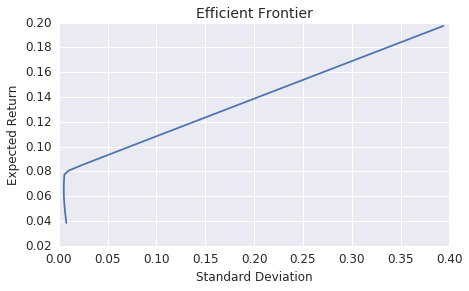

,returns,risks,weights
0,0.038427,0.007719,"{u'000300.ZICN': 2.33603637691e-09, u'000905.Z..."
1,0.041670,0.007210,"{u'000300.ZICN': 0.000184987938987, u'000905.Z..."
2,0.044913,0.006733,"{u'000300.ZICN': 0.000163602631128, u'000905.Z..."
3,0.048156,0.006300,"{u'000300.ZICN': 0.00039631472914, u'000905.ZI..."
4,0.051399,0.005908,"{u'000300.ZICN': 7.98325463855e-05, u'000905.Z..."


In [ ]:
efficient_frontier = get_BL_efficient_frontier(return_table,tau,P=P,Q=Q,Omega=Omega,allow_short=False, n_samples=50)
draw_efficient_frontier(efficient_frontier)
efficient_frontier.head()

- 计算调整期望收益后的最小方差组合权重

In [ ]:
get_BL_minimum_variance_portfolio(return_table,tau=0.05,P=P,Q=Q,Omega=Omega, allow_short=False, show_details=True)

Minimum Variance Portfolio:
    Short Allowed: False
    Portfolio Return: 0.0658687283917
    Portfolio Volatility: 0.0050588418931
    Portfolio Weights: 
	000300.ZICN: 0.0%
	000905.ZICN: 0.0%
	399006.ZICN: 0.0%
	000013.ZICN: 68.4%
	000012.ZICN: 31.6%


{'000012.ZICN': 0.31560658374348943,
 '000013.ZICN': 0.6841910861679561,
 '000300.ZICN': 9.9297573033722776e-05,
 '000905.ZICN': 4.5874020869208056e-05,
 '399006.ZICN': 5.7158494651462556e-05}

- 计算调整期望收益后的最大效用组合权重

In [ ]:
get_BL_maximum_utility_portfolio(return_table,tau=0.05,P=P,Q=Q,Omega=Omega, risk_aversion=3., allow_short=False, show_details=True)

Maximum Utility Portfolio:
    Risk Aversion: 3.0
    Short Allowed: False
    Portfolio Return: 0.160427218842
    Portfolio Volatility: 0.101067603354
    Portfolio Weights: 
	000300.ZICN: 0.0%
	000905.ZICN: 0.0%
	399006.ZICN: 25.5%
	000013.ZICN: 74.5%
	000012.ZICN: 0.0%


{'000012.ZICN': 2.5108250455698692e-08,
 '000013.ZICN': 0.74451966742282516,
 '000300.ZICN': 1.9315441226770764e-07,
 '000905.ZICN': 1.8268795739024269e-07,
 '399006.ZICN': 0.25547993162655475}

- 计算调整期望收益后的最大夏普比率组合权重

In [ ]:
get_maximum_sharpe_portfolio(return_table, riskfree_rate=0.,tau=0.05,P=P,Q=Q,Omega=Omega,allow_short=True, show_details=True)

Maximum Sharpe Portfolio:
    Riskfree Rate: 0.0
    Short Allowed: True
    Portfolio Return: 0.0737395282834
    Portfolio Volatility: 0.00531414656153
    Portfolio Sharpe: 13.8760810282
    Portfolio Weights: 
	000300.ZICN: 0.2%
	000905.ZICN: -0.4%
	399006.ZICN: 0.2%
	000013.ZICN: 88.4%
	000012.ZICN: 11.7%


{'000012.ZICN': 0.11651327649417914,
 '000013.ZICN': 0.8843989671769028,
 '000300.ZICN': 0.0015401399721855877,
 '000905.ZICN': -0.004275475553003543,
 '399006.ZICN': 0.0018230919097360272}